#Анализ тональности

###Импорты

In [124]:
%matplotlib inline

import json
import math

import numpy
import matplotlib.pyplot as plot

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics, decomposition

###Функция для F1 меры

In [25]:
def f1_measure(P,R):
    return [2*x*y/(x+y) for x,y in zip(P, R)]

###Чтение файлов, bag of words, множество ответов

In [122]:
with open('pos_reviews.json') as data_file:    
    data_pos = json.load(data_file)
with open('neg_reviews.json') as data_file:    
    data_neg = json.load(data_file)

pos_texts = data_pos.keys()
neg_texts = data_neg.keys()
all_texts = pos_texts + neg_texts

N_POS_TEXTS = len(pos_texts)
N_NEG_TEXTS = len(neg_texts)
target = [1]*N_POS_TEXTS + [0]*N_NEG_TEXTS

###Матрица частотности

In [27]:
count_vect = CountVectorizer()
temp_matrix = count_vect.fit_transform(all_texts)
matrix_counts = temp_matrix.toarray()

###Бинарная матрица встречаемости

In [28]:
count_vect_bin = CountVectorizer(binary=True)
matrix_counts_bin = count_vect_bin.fit_transform(all_texts).toarray()

### Матрицы частотности и встречаемости для биграм

In [6]:
count_vect = CountVectorizer(ngram_range=(1, 2))
matrix_counts_bigram = count_vect.fit_transform(all_texts).toarray()

count_vect_bin = CountVectorizer(ngram_range=(1, 2), binary=True)
matrix_counts_bin_bigram = count_vect_bin.fit_transform(all_texts).toarray()

### Матрицы частотности и встречаемости для триграм

In [7]:
count_vect = CountVectorizer(ngram_range=(3, 3))
matrix_counts_trigram = count_vect.fit_transform(all_texts).toarray()

count_vect_bin = CountVectorizer(ngram_range=(3, 3), binary=True)
matrix_counts_bin_trigram = count_vect_bin.fit_transform(all_texts).toarray()

###TF-IDF матрица

In [29]:
tfidf_transformer = TfidfTransformer()
matrix_tfidf = tfidf_transformer.fit_transform(temp_matrix).toarray()

###Relevance Frequency

In [137]:
def get_after_rf_matrix(in_matrix, in_matrix_bin, IN_N_POS_TEXTS, IN_N_NEG_TEXTS, out_n_features):
    '''first text in all matrix mast be positive'''
    pos_rf_prepare = in_matrix_bin[:IN_N_POS_TEXTS].sum(axis=0) 
    neg_rf_prepare = in_matrix_bin[IN_N_POS_TEXTS:].sum(axis=0)
    pos_rf = numpy.array([math.log( 2 + (x / max(1,y)) , 2) for x,y in zip(pos_rf_prepare, neg_rf_prepare)])
    neg_rf = numpy.array([math.log( 2 + (x / max(1,y)) , 2) for x,y in zip(neg_rf_prepare, pos_rf_prepare)])
    l_pos = pos_rf.argsort()[-out_n_features//2:]
    l_neg = neg_rf.argsort()[-out_n_features//2:]
    return (in_matrix.transpose()[list(set(l_pos) | set(l_neg))]).transpose()

def get_after_rf_matrix_slow(in_matrix, in_matrix_bin, IN_N_POS_TEXTS, IN_N_NEG_TEXTS, out_n_features):
    '''first text in all matrix mast be positive'''
    pos_rf_prepare = in_matrix_bin[:IN_N_POS_TEXTS].sum(axis=0) 
    neg_rf_prepare = in_matrix_bin[IN_N_POS_TEXTS:].sum(axis=0)
    pos_rf = numpy.array([math.log( 2 + (x / max(1,y)) , 2) for x,y in zip(pos_rf_prepare, neg_rf_prepare)])
    neg_rf = numpy.array([math.log( 2 + (x / max(1,y)) , 2) for x,y in zip(neg_rf_prepare, pos_rf_prepare)])
    l_pos = pos_rf.argsort()[-out_n_features//2:]
    l_neg = neg_rf.argsort()[-out_n_features//2:]
    
    
    in_matrix_transposed = matrix_counts_trigram.transpose()
    list_of_rows = list(set(l_pos) | set(l_neg))
    temp_array = []
    for row in list_of_rows:
        temp_array.append(in_matrix_transposed[row].tolist())

    return numpy.array(temp_array).transpose()

###PCA

In [8]:
from MyPCA import PCA
def get_after_pca_matrix(in_matrix, n_features):
    pca = PCA(n_components=n_features)
    pca.fit(in_matrix)
    return pca.transform(in_matrix)

###Кросс-валидация

In [36]:
def cross_valid(matrix_counts, target, test_size=0.3, random_state=0):
    X_train, X_test, Y_train, Y_test = train_test_split(matrix_counts, target, test_size=0.3, random_state=0)
    return (X_train, X_test, Y_train, Y_test)

###Функции для рисования Recall-Precision и ROC кривой

In [117]:
def rp_curve(title, Y_test, predicted, label='?'):
    precision, recall, _ = metrics.precision_recall_curve(Y_test, predicted[:,1])
    plot.plot(recall, precision, label='R-P '+label);
    plot.plot(recall, f1_measure(precision, recall), label='F1 '+label)
    plot.xlabel('Recall'); plot.ylabel('Precision'); plot.title(title)
    plot.legend(bbox_to_anchor=(1, 1), loc=2); plot.xlim([0.0, 1.0]); plot.ylim([0.0, 1]);
    
def rp_no_proba_curve(title, Y_test, predicted, label='?'):
    precision, recall, _ = metrics.precision_recall_curve(Y_test, predicted[:])
    plot.plot(recall, precision, label='R-P '+label);
    plot.plot(recall, f1_measure(precision, recall), label='F1 '+label)
    plot.xlabel('Recall'); plot.ylabel('Precision'); plot.title(title)
    plot.legend(bbox_to_anchor=(1, 1), loc=2); plot.xlim([0.0, 1.0]); plot.ylim([0.0, 1]);
    
def roc_curve(title, Y_test, predicted, label='?'):
    fpr, tpr, _ = metrics.roc_curve(Y_test, predicted[:,1])
    plot.plot(fpr, tpr, label=label);
    plot.xlabel('False Positive'); plot.ylabel('True Positive'); plot.title(title)
    plot.legend(bbox_to_anchor=(1, 1), loc=2); plot.xlim([0.0, 1.0]); plot.ylim([0.0, 1]);
    print 'Logistic Regression (', label, ') AUC = ', metrics.auc(fpr, tpr)
    
def roc_no_proba_curve(title, Y_test, predicted, label='?'):
    fpr, tpr, _ = metrics.roc_curve(Y_test, predicted[:])
    plot.plot(fpr, tpr, label=label);
    plot.xlabel('False Positive'); plot.ylabel('True Positive'); plot.title(title)
    plot.legend(bbox_to_anchor=(1, 1), loc=2); plot.xlim([0.0, 1.0]); plot.ylim([0.0, 1]);
    print 'Logistic Regression (', label, ') AUC = ', metrics.auc(fpr, tpr)

###Логистическая регрессия

In [110]:
def logistic_reg(X_train, X_test, Y_train, **kwargs):
    model_logistic = LogisticRegression(**kwargs)
    model_logistic.fit(X_train, Y_train)
    predicted = model_logistic.predict_proba(X_test)
    return predicted

###Деление выборки

In [111]:
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts, target)

###Логистическая регрессия на всех данных

In [112]:
logreg_1_predicted = logistic_reg(X_train, X_test, Y_train)

###Логистическая регрессия на всех данных, penalty='l1'

In [113]:
logreg_2_predicted = logistic_reg(X_train, X_test, Y_train, penalty='l1')

###Сравнения логистической регрессии

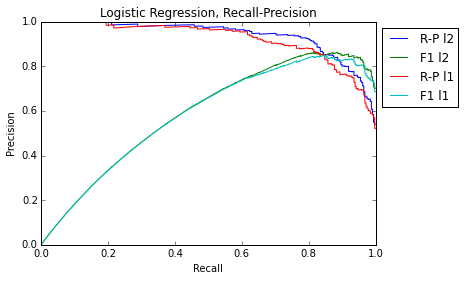

In [118]:
rp_curve('Logistic Regression, Recall-Precision', Y_test, logreg_1_predicted, label='l2')
rp_curve('Logistic Regression, Recall-Precision', Y_test, logreg_2_predicted, label='l1')

Logistic Regression ( l2 ) AUC =  0.931306706992
Logistic Regression ( l1 ) AUC =  0.91215975805


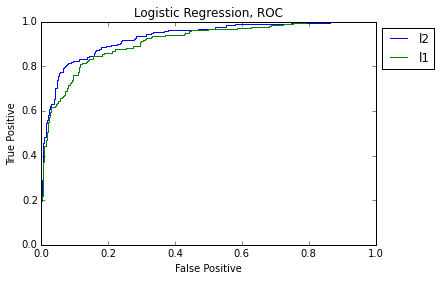

In [119]:
roc_curve('Logistic Regression, ROC', Y_test, logreg_1_predicted, label='l2')
roc_curve('Logistic Regression, ROC', Y_test, logreg_2_predicted, label='l1')

###Сравнение логистической регрессии обычной с биграммной и триграммной

In [19]:
X_train_bigram, X_test_bigram, Y_train_bigram, Y_test_bigram = cross_valid(matrix_counts_bigram, target)
logreg_bigram_predicted = logistic_reg(X_train_bigram, X_test_bigram, Y_train_bigram)

In [21]:
matrix_counts_trigram = get_after_rf_matrix_slow(matrix_counts_trigram, matrix_counts_bin_trigram, N_POS_TEXTS, N_NEG_TEXTS, 1000)

In [ ]:
X_train_trigram, X_test_trigram, Y_train_trigram, Y_test_trigram = cross_valid(matrix_counts_trigram, target)
logreg_trigram_predicted = logistic_reg(X_train_trigram, X_test_trigram, Y_train_trigram)

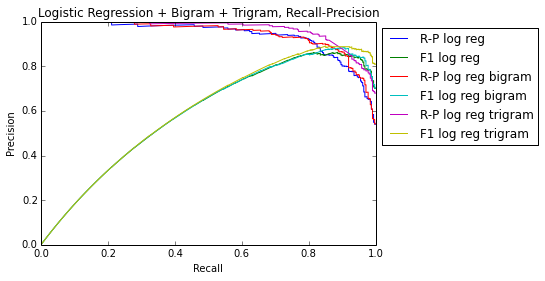

In [23]:
rp_curve('Logistic Regression + Bigram + Trigram, Recall-Precision', Y_test, logreg_1_predicted, label='log reg')
rp_curve('Logistic Regression + Bigram + Trigram, Recall-Precision', Y_test_bigram, logreg_bigram_predicted, label='log reg bigram')
rp_curve('Logistic Regression + Bigram + Trigram, Recall-Precision', Y_test_trigram, logreg_trigram_predicted, label='log reg trigram')

Logistic Regression ( log reg ) AUC =  0.931306706992
Logistic Regression ( log reg bigram ) AUC =  0.938522949653
Logistic Regression ( log reg trigram ) AUC =  0.961889565914


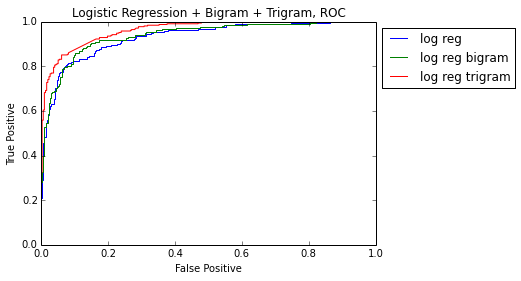

In [24]:
roc_curve('Logistic Regression + Bigram + Trigram, ROC', Y_test, logreg_1_predicted, label='log reg')
roc_curve('Logistic Regression + Bigram + Trigram, ROC', Y_test_bigram, logreg_bigram_predicted, label='log reg bigram')
roc_curve('Logistic Regression + Bigram + Trigram, ROC', Y_test_trigram, logreg_trigram_predicted, label='log reg trigram')

###AdaBoost для RandomForest

In [27]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
n_estimators_rf = 4500

random_forest_classifier = RandomForestClassifier(n_estimators=n_estimators_rf)
random_forest_classifier.fit(X_train, Y_train)
predicted_random_forest = random_forest_classifier.predict_proba(X_test)

adaboost_classyfier = AdaBoostClassifier(RandomForestClassifier(n_estimators=n_estimators_rf), n_estimators=10)
adaboost_classyfier.fit(X_train, Y_train)
predicted_adaboost = adaboost_classyfier.predict_proba(X_test)

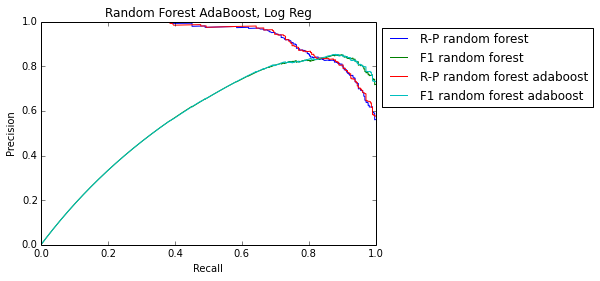

In [29]:
rp_curve('Random Forest AdaBoost, Random Forest', Y_test, predicted_random_forest, label='random forest')
rp_curve('Random Forest AdaBoost, Random Forest', Y_test, predicted_adaboost, label='random forest adaboost')

Logistic Regression ( random forest ) AUC =  0.923128669276
Logistic Regression ( random forest adaboost ) AUC =  0.924963307241


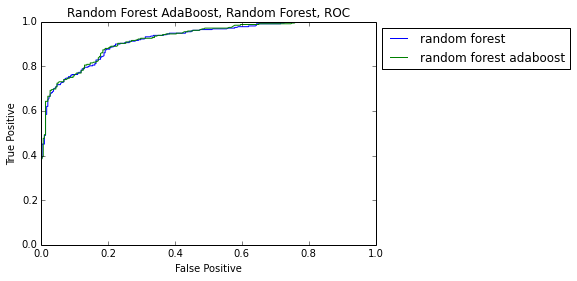

In [35]:
roc_curve('Random Forest AdaBoost, Random Forest, ROC', Y_test, predicted_random_forest, label='random forest')
roc_curve('Random Forest AdaBoost, Random Forest, ROC', Y_test, predicted_adaboost, label='random forest adaboost')

###AdaBoost для LogisticRegression

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

logreg_regressor_adaboost = AdaBoostRegressor(LogisticRegression(), n_estimators=100)
logreg_regressor_adaboost.fit(X_train, Y_train)
predicted_logreg_adaboost = logreg_regressor_adaboost.predict(X_test)

logreg_regressor =LogisticRegression()
logreg_regressor.fit(X_train, Y_train)
predicted_logreg = logreg_regressor.predict(X_test)

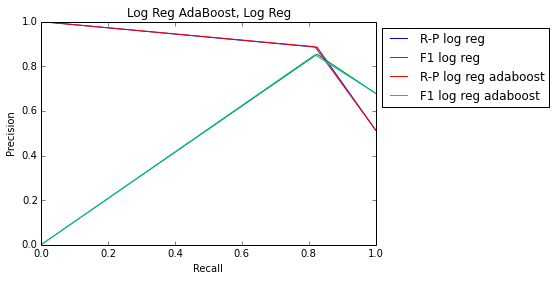

In [31]:
rp_no_proba_curve('Log Reg AdaBoost, Log Reg', Y_test, predicted_logreg, label='log reg')
rp_no_proba_curve('Log Reg AdaBoost, Log Reg', Y_test, predicted_logreg_adaboost, label='log reg adaboost')

Logistic Regression ( log reg ) AUC =  0.855830813023
Logistic Regression ( log reg adaboost ) AUC =  0.854296388543


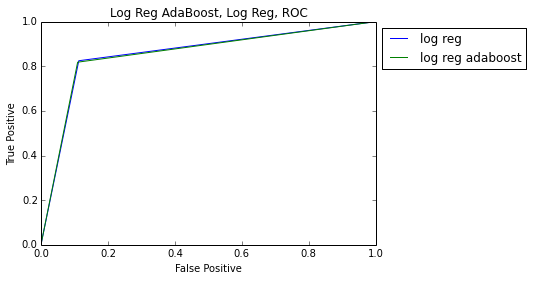

In [39]:
roc_no_proba_curve('Log Reg AdaBoost, Log Reg, ROC', Y_test, predicted_logreg, label='log reg')
roc_no_proba_curve('Log Reg AdaBoost, Log Reg, ROC', Y_test, predicted_logreg_adaboost, label='log reg adaboost')

###Сравнение RF и RF+PCA

In [ ]:
rf_10000_matrix = get_after_rf_matrix(matrix_counts, matrix_counts_bin, N_POS_TEXTS, N_NEG_TEXTS, 10000)
X_train, X_test, Y_train, Y_test = cross_valid(rf_10000_matrix, target)
logreg_rf_predicted = logistic_reg(X_train, X_test, Y_train)

precision, recall, _ = metrics.precision_recall_curve(Y_test, logreg_rf_predicted[:,1])
max_f1_for_n_features = max(f1_measure(precision, recall))
print "max F1 for RF", max_f1_for_n_features
print rf_10000_matrix.shape

n_features_array = range(2000, 12000, 2000)
maxf1_array = []
for n_features in n_features_array:
    print "N features", n_features
    rf_pca_3000_matrix = get_after_pca_matrix(rf_10000_matrix, n_features)
    print rf_pca_3000_matrix.shape
    X_train, X_test, Y_train, Y_test = cross_valid(rf_pca_3000_matrix, target)
    logreg_rf_pca_predicted = logistic_reg(X_train, X_test, Y_train)
    precision, recall, _ = metrics.precision_recall_curve(Y_test, logreg_rf_pca_predicted[:,1])
    max_f1_for_n_features = max(f1_measure(precision, recall))
    maxf1_array.append(max_f1_for_n_features)
    print "max F1 for RF+PCA with these features", max_f1_for_n_features

plot.plot(n_features_array, maxf1_array)


In [ ]:
rp_curve('Logistic Regression, Recall-Precision', Y_test, logreg_rf_predicted, label='rf to 10000')
rp_curve('Logistic Regression, Recall-Precision', Y_test, logreg_rf_pca_predicted, label='rf+pca to 3000')

###Вычисление оптимального количества фич для Relevance Frequency

In [ ]:
n_features_array = range(100, 30000, 50)
maxf1_array = []
log_n_features = False #just to see progress in case of short steps
for n_features in n_features_array:
    if log_n_features:
        print n_features 
    rf_n_matrix = get_after_rf_matrix(matrix_counts, matrix_counts_bin, N_POS_TEXTS, N_NEG_TEXTS, n_features)
    X_train, X_test, Y_train, Y_test = cross_valid(rf_n_matrix, target)
    logreg_with_predicted = logistic_reg(X_train, X_test, Y_train)
    precision, recall, _ = metrics.precision_recall_curve(Y_test, logreg_with_predicted[:,1])
    max_f1_for_n_features = max(f1_measure(precision, recall))
    maxf1_array.append(max_f1_for_n_features)

global_max_f1 = max(maxf1_array)
print "Global max F1:", global_max_f1
index = maxf1_array.index(global_max_f1)
print "N features:", n_features_array[index]

plot.plot(n_features_array, maxf1_array)

###Вычисление оптимального количества фич для PCA

In [ ]:
n_features_array = range(100, 1900, 50)
maxf1_array = []
log_n_features = True #just to see progress in case of short steps
for n_features in n_features_array:
    if log_n_features:
        print n_features 
    pca_n_matrix = get_after_pca_matrix(matrix_counts, n_features)
    X_train, X_test, Y_train, Y_test = cross_valid(pca_n_matrix, target)
    logreg_with_predicted = logistic_reg(X_train, X_test, Y_train)
    precision, recall, _ = metrics.precision_recall_curve(Y_test, logreg_with_predicted[:,1])
    max_f1_for_n_features = max(f1_measure(precision, recall))
    maxf1_array.append(max_f1_for_n_features)

global_max_f1 = max(maxf1_array)
print "Global max F1:", global_max_f1
index = maxf1_array.index(global_max_f1)
print "N features:", n_features_array[index]

plot.plot(n_features_array, maxf1_array)

###сравнение RF и простой логистической регрессией 

In [138]:
rf_2000_matrix = get_after_rf_matrix(matrix_counts, matrix_counts_bin, N_POS_TEXTS, N_NEG_TEXTS, 5000)
X_train, X_test, Y_train, Y_test = cross_valid(rf_2000_matrix, target)
logreg_3_predicted = logistic_reg(X_train, X_test, Y_train)

###Графики для RF

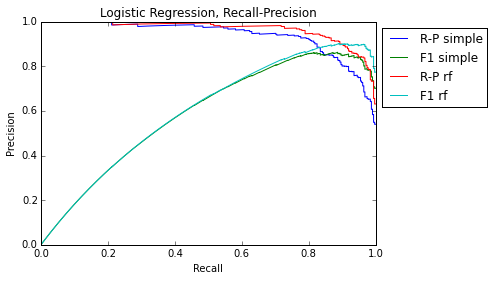

In [139]:
rp_curve('Logistic Regression, Recall-Precision', Y_test, logreg_1_predicted, label='simple')
rp_curve('Logistic Regression, Recall-Precision', Y_test, logreg_3_predicted, label='rf')

Logistic Regression ( simple ) AUC =  0.931306706992
Logistic Regression ( rf ) AUC =  0.964619284825


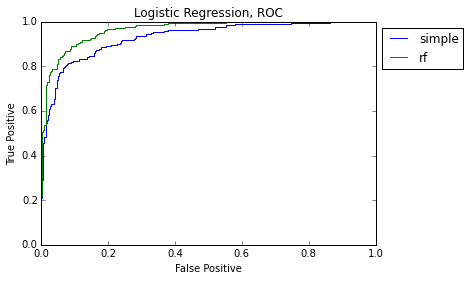

In [140]:
roc_curve('Logistic Regression, ROC', Y_test, logreg_1_predicted, label='simple')
roc_curve('Logistic Regression, ROC', Y_test, logreg_3_predicted, label='rf')